In [30]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.linear_model import LinearRegression

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
print("Seed: 42")

Seed: 42


In [13]:
DATA_PATH = "../data/cleveland.csv"
COLUMNS = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

raw = pd.read_csv(DATA_PATH, header=None)
raw.columns = COLUMNS

for c in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca','thal']:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')

raw['target'] = (raw['target'] > 0).astype(int)
print("shape:", raw.shape)
display(raw.head())
display(raw.isna().sum())

shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

In [14]:
numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

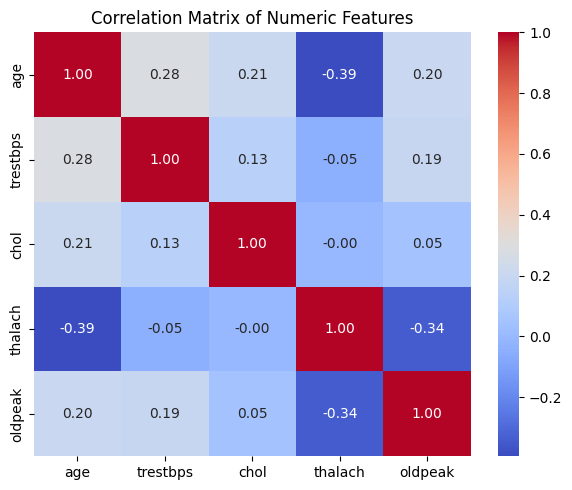

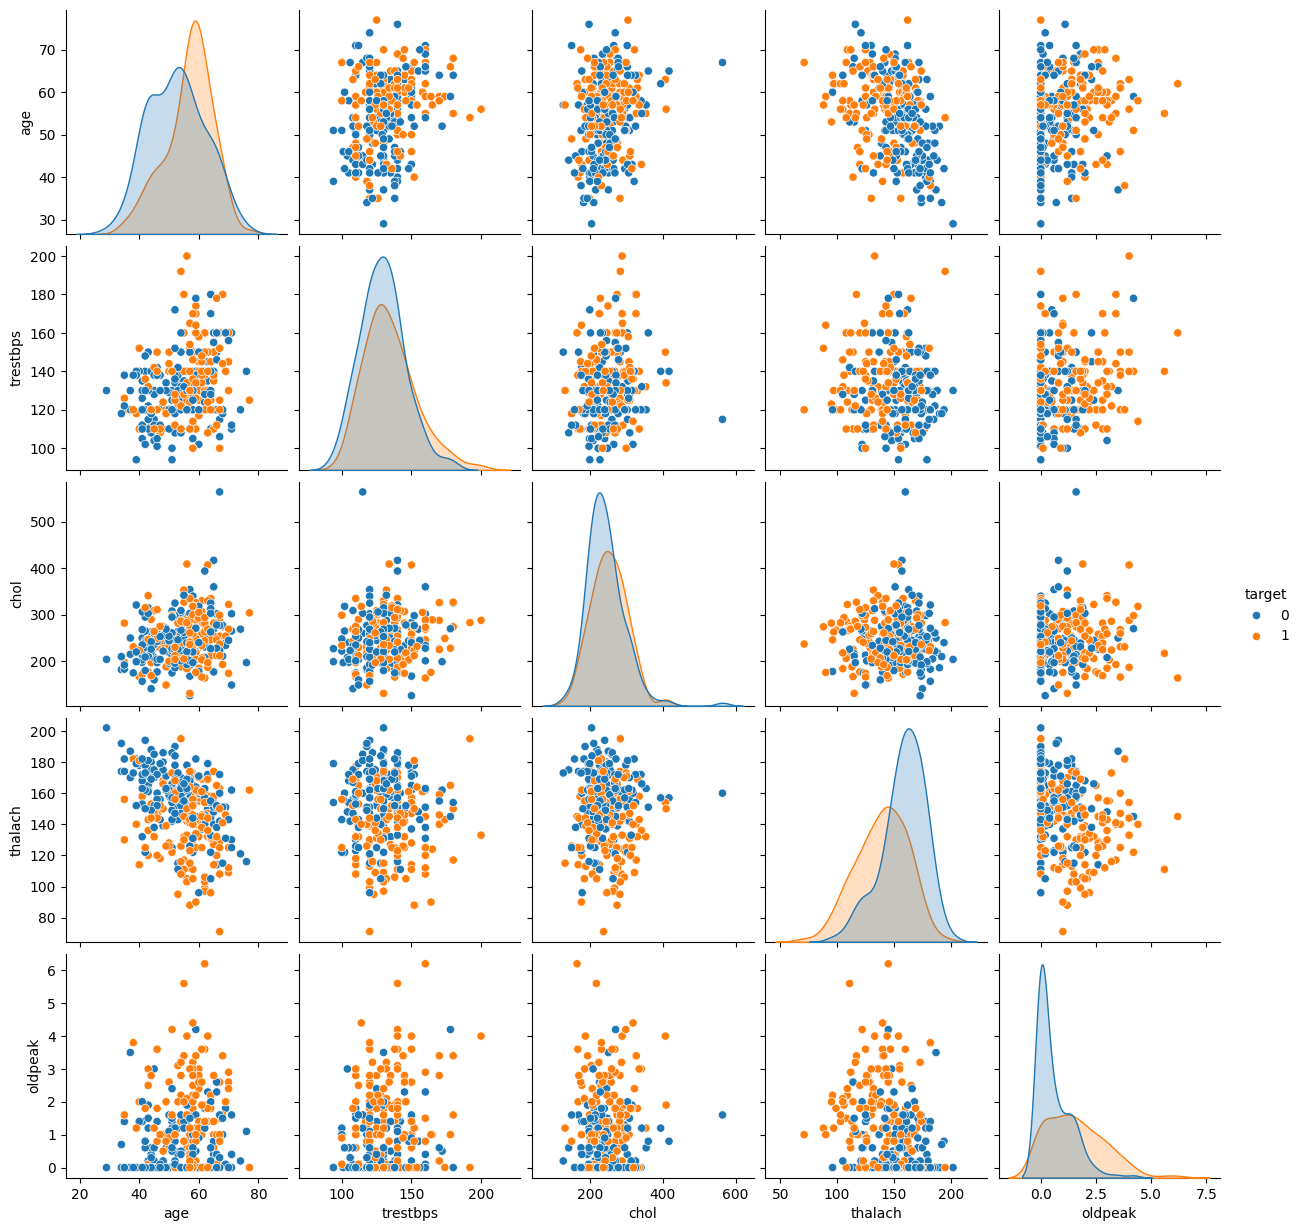

<Figure size 1000x1000 with 0 Axes>

In [18]:
plt.figure(figsize=(6,5))
corr_matrix = raw[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

sns.pairplot(raw, vars = numeric_cols, hue='target', diag_kind='kde')
plt.figure(figsize=(10,10))
plt.suptitle("Pairplot of Numeric Features Colored by Target", y=1.02)
plt.show()

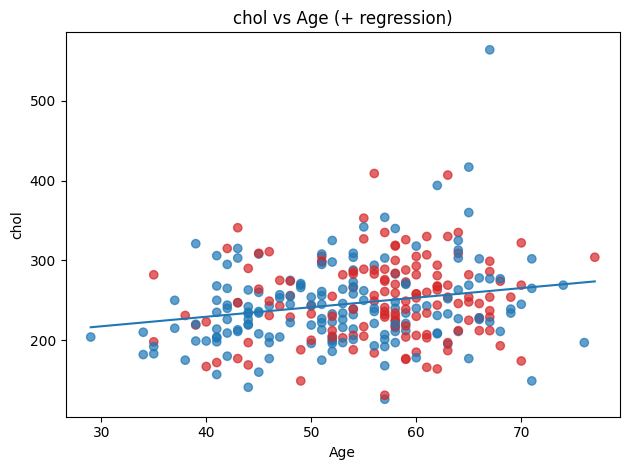

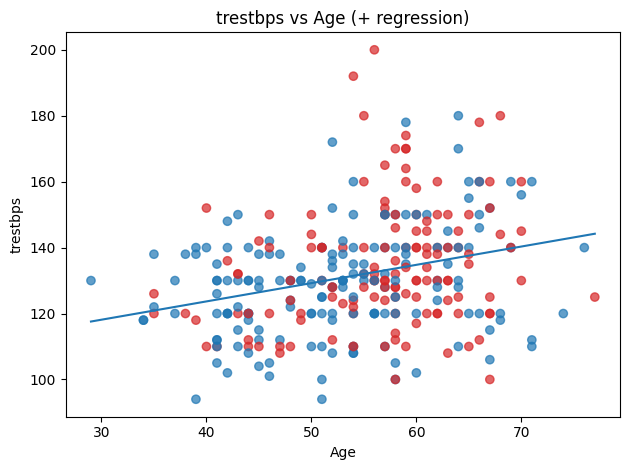

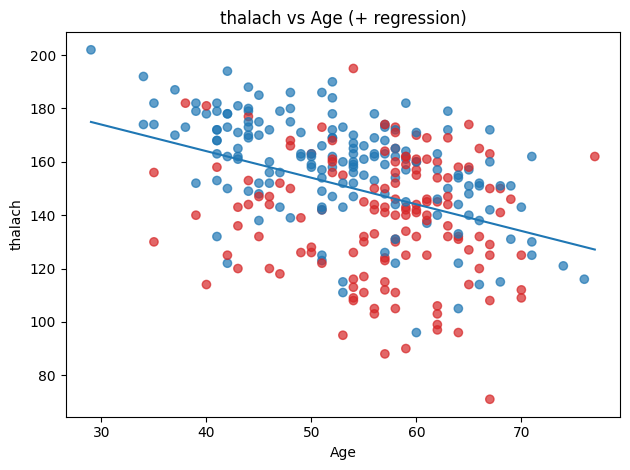

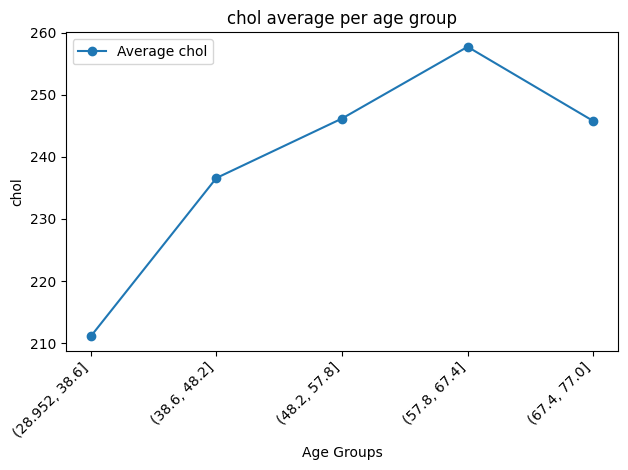

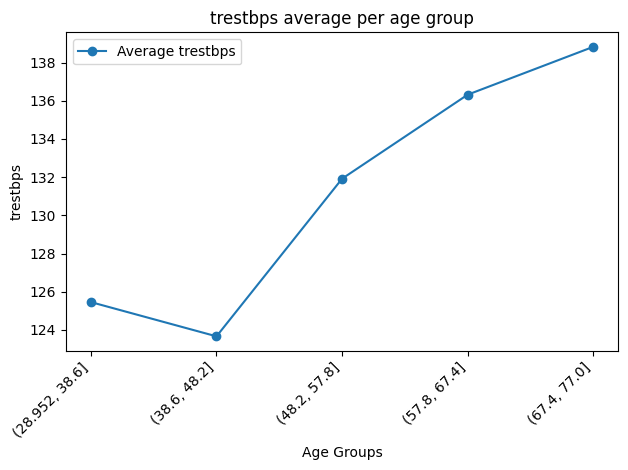

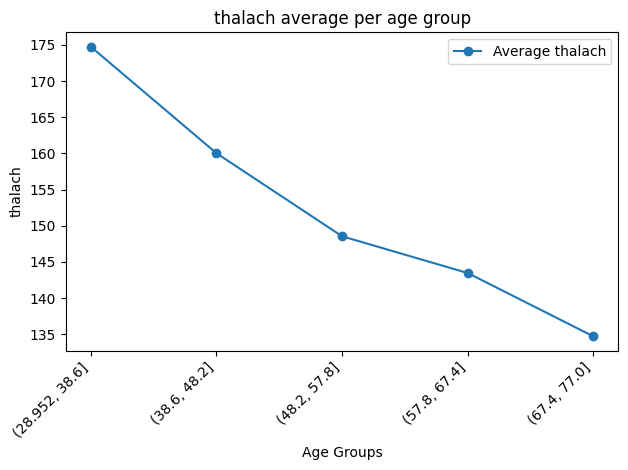

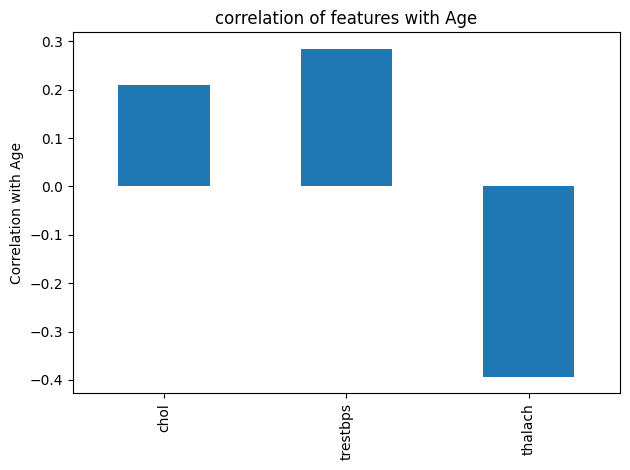

In [21]:
X, y = raw.drop('target', axis=1), raw['target']
colors = np.where(y==0, "tab:blue", "tab:red")
metrics = [c for c in ['chol', 'trestbps', 'thalach'] if c in X.columns]

def scatter_with_regression(xs, ys, xlab, ylab, title):
    m = xs.notna() & ys.notna()
    x, yy = xs[m].values, ys[m].values
    plt.figure()
    plt.scatter(xs, ys, c=colors, alpha=0.7)
    if len(x) > 1:
        k, b = np.polyfit(x, yy, 1)
        xline = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        plt.plot(xline, k*xline + b)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()
    plt.show()

if "age" in X.columns and metrics:
    for col in metrics:
        scatter_with_regression(
            X["age"], X[col],
            "Age", ylab=col,
            title=f"{col} vs Age (+ regression)")

if "age" in X.columns and metrics:
    age_bins = pd.cut(X["age"], bins= 5)
    for m in metrics:
        plt.figure()
        avg_vals = X.groupby(age_bins, observed=True)[m].mean()
        plt.plot(range(len(avg_vals)), avg_vals, marker='o', label=f"Average {m}")
        plt.xticks(
            range(len(avg_vals)), map(str, avg_vals.index), rotation=45, ha='right'
        )
        plt.xlabel("Age Groups")
        plt.ylabel(m)
        plt.title(f"{m} average per age group")
        plt.legend()
        plt.tight_layout()
        plt.show()

cols = [c for c in ["age", "chol", "trestbps", "thalach"] if c in X.columns]
if "age" in cols:
    corr = X[cols].corr(numeric_only=True)["age"].drop("age", errors='ignore')
    plt.figure(); corr.plot(kind='bar')
    plt.ylabel("Correlation with Age")
    plt.title("correlation of features with Age")
    plt.tight_layout()
    plt.show()

In [23]:
TARGET = "target"
feat_cols = raw.columns.drop(TARGET)
X_all, y_all = raw[feat_cols], raw[TARGET]
K= len(feat_cols)

num_proc = Pipeline([("imp", SimpleImputer(strategy = "median")),
                     ("sc", StandardScaler())])
cat_proc = Pipeline([('imp', SimpleImputer(strategy = 'most_frequent')),
                     ('sc', MinMaxScaler())])

preprocess = ColumnTransformer([
    ('num', num_proc, numeric_cols),
    ('cat', cat_proc, categorical_cols),
], verbose_feature_names_out=False).set_output(transform="pandas")

raw_pipeline = Pipeline([("preprocess", preprocess)])

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42,
)

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test = raw_pipeline.transform(X_test)

out_dir = Path("../data/raw"); out_dir.mkdir(parents=True, exist_ok=True)
for name, (X_, y_) in {
    "raw_train": (X_raw_train, y_train),
    "raw_val": (X_raw_val, y_val),
    "raw_test": (X_raw_test, y_test),
}.items():
    pd.concat(
        [X_, y_.rename(TARGET)], axis=1
    ).to_csv(out_dir / f"{name}.csv", index=False)

print(f"Saved RAW splits. K (RAW features) = {K}")
display(X_raw_train)
display(X_raw_train.isna().sum())


Saved RAW splits. K (RAW features) = 13


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
180,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0
208,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0
167,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0
105,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0
297,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.829818,0.514117,2.733557,0.310836,0.179210,0.0,1.000000,0.0,1.0,0.0,0.5,0.000000,0.0
136,1.720848,0.798433,-1.438042,-1.102621,1.428521,1.0,1.000000,0.0,0.0,1.0,1.0,0.000000,1.0
2,1.386712,-0.623144,-0.395142,-0.925938,1.428521,1.0,1.000000,0.0,1.0,1.0,0.5,0.666667,1.0
189,1.609469,0.514117,0.078903,-0.175039,0.893102,1.0,0.666667,0.0,1.0,0.0,0.5,1.000000,1.0


age         0
trestbps    0
chol        0
thalach     0
oldpeak     0
sex         0
cp          0
fbs         0
restecg     0
exang       0
slope       0
ca          0
thal        0
dtype: int64

Saved FE splits. K (FE features) = 13


0      thal_3.0
1      thal_7.0
2        cp_4.0
3        ca_0.0
4     exang_1.0
5     exang_0.0
6       oldpeak
7     slope_1.0
8          chol
9     slope_2.0
10      thalach
11     hr_ratio
12      sex_0.0
Name: fe_topk_features, dtype: object

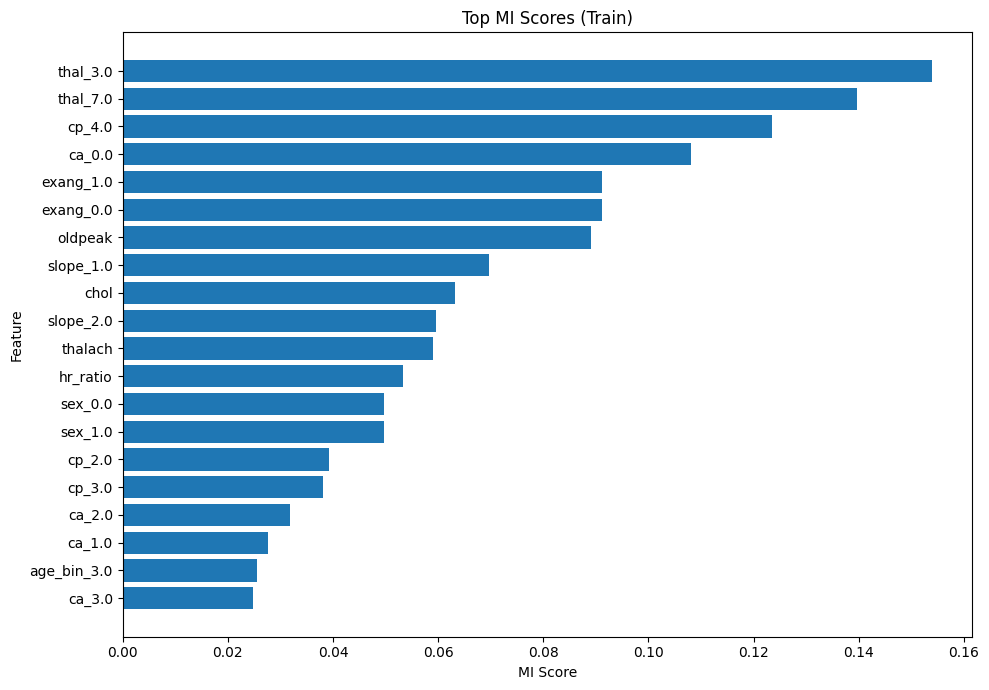

In [26]:
def add_new_features(df):
    df = df.copy()
    if {'chol', 'age'} <= set(df.columns):
        df['chol_per_age'] = df['chol'] / (df['age'])
    if {"trestbps", 'age'} <= set(df.columns):
        df['bps_per_age'] = df['trestbps'] / (df['age'])
    if {'thalach', 'age'} <= set(df.columns):
        df['hr_ratio'] = df['thalach'] / (df['age'])
    if "age" in df.columns:
        df['age_bin'] = pd.cut(df['age'], bins=5, labels=False).astype("category")
    return df

gen_num = ["chol_per_age", "bps_per_age", "hr_ratio"]
gen_cat = ["age_bin"]

all_nums = [c for c in numeric_cols] + gen_num
all_cats = [c for c in categorical_cols] + gen_cat

num_proc = Pipeline([("imp", SimpleImputer(strategy = "median")),
                    ("sc", StandardScaler())])
cat_proc = Pipeline([('imp', SimpleImputer(strategy = 'most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown = 'ignore', sparse_output=False))])

pre = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform="pandas")

fe_pre = Pipeline([
    ("gen_feat", FunctionTransformer(add_new_features, validate=False)),
    ("pre", pre),
]).set_output(transform="pandas")

Xt_tr = fe_pre.fit_transform(X_train, y_train)
Xt_va = fe_pre.transform(X_val)
Xt_te = fe_pre.transform(X_test)

nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna= False) > 1]
Xt_tr, Xt_va, Xt_te = Xt_tr[nz_cols], Xt_va[nz_cols], Xt_te[nz_cols]

ohe = fe_pre.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"]
cat_names = list(ohe.get_feature_names_out(all_cats))
is_discrete = np.array([c in cat_names for c in Xt_tr.columns], dtype=bool)

mi = mutual_info_classif(Xt_tr.values, y_train.values, discrete_features = is_discrete, random_state=42)
mi_series = pd.Series(mi, index=Xt_tr.columns).sort_values(ascending=False)

K = raw.columns.drop("target").shape[0]
topk_cols = list(mi_series.head(K).index)

fe_tr = Xt_tr[topk_cols].assign(target = y_train.values)
fe_va = Xt_va[topk_cols].assign(target = y_val.values)
fe_te = Xt_te[topk_cols].assign(target = y_test.values)

out = Path("../data/fe"); out.mkdir(parents=True, exist_ok=True)
fe_tr.to_csv(out/"fe_train.csv", index=False)
fe_va.to_csv(out/"fe_val.csv", index=False)
fe_te.to_csv(out/"fe_test.csv", index=False)

print(f"Saved FE splits. K (FE features) = {K}")
display(pd.Series(topk_cols, name="fe_topk_features").reset_index(drop=True))

N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]
plt.figure(figsize=(10, max(6, 0.35*N)))
plt.barh(topN.index, topN.values)
plt.title("Top MI Scores (Train)")
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()